In [97]:
## General dependencies not needed for the modules themselves

import os, sys
sys.path.append('../../')

import warnings
import collections
from random import sample, seed

import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader, default_collate
from tqdm.auto import tqdm
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
from dataset import CalgaryCampinasDataset, ACDCDataset, MNMDataset
from model.unet import UNet2D, UNetEnsemble
from model.ae import AE
from model.dae import resDAE, AugResDAE
from model.wrapper import Frankenstein
from losses import (
    DiceScoreCalgary, 
    DiceScoreMMS, 
    SurfaceDiceCalgary, 
    AccMMS
)
from utils import volume_collate
from eval.slice_wise import (
    PoolingMahalabonisDetector, 
    AEMahalabonisDetector, 
    MeanDistSamplesDetector, 
    EntropyDetector, 
    EnsembleEntropyDetector
)

In [2]:
## Dependencies for UMapScorePerSlice

import os
import random
from typing import (
    Iterable, 
    Dict, 
    Callable, 
    Tuple, 
    Union, 
    List
)
from copy import deepcopy
import numpy as np
import torch
from torch import Tensor, nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min, auc
import nibabel as nib
import wandb
import matplotlib.pyplot as plt

In [3]:
    
### Evaluation
class UMapScorePerSlice(nn.Module):
    """Calculates scores for each input slice.
    """
        
    def __init__(
        self, 
        reduction: str
    ):
        super().__init__()
        self.r = reduction
        # TODO: default to keep only first dim,
        #       flexible where possible (e.g. mean)
        self.dim = (1,2,3)
        
    @torch.no_grad()
    def forward(
        self, 
        umap:   Tensor = None, 
        pred:   Tensor = None, # original segmentation prediction
        pred_r: Tensor = None  # re-sampled segmentation prediction
    ) -> Tensor:
        if self.r == 'mean':
            assert umap is not None, "reduction is set to mean over umap, but umap is None"
            return umap.mean()
        
        elif self.r == 'norm':
            # The frobenius (i.e. euclidean) norm is simply the sum of squared elements, square rooted
            assert umap is not None, "reduction is set to norm of umap, but umap is None"
            # assert self.dim == (1,2,3), "setting the dim parameter doesn't do anything for norm reduction"
            return torch.norm(umap)
        
        elif self.r == 'nflips':
            assert pred is not None, "reduction is set to fraction of flipped predictions, but pred is None"
            assert pred_r is not None, "reduction is set to fraction of flipped predictions, but pred_r is None"
            flip_mask = (torch.argmax(pred, dim=1, keepdim=True) != torch.argmax(pred_r, dim=1, keepdim=True)) * 1
            return flip_mask.sum()
        
        elif self.r == 'nNflips':
            assert pred is not None, "reduction is set to number of flipped predictions, but pred is None"
            assert pred_r is not None, "reduction is set to number of flipped predictions, but pred_r is None"
            flip_mask = (torch.argmax(pred, dim=1, keepdim=True) != torch.argmax(pred_r, dim=1, keepdim=True)) * 1.
            return flip_mask.mean()

In [4]:
# Dependencies for MeanDistSamplesDetector

from typing import Iterable, Dict, List, Callable, Tuple, Union, List

import torch #
from torch import Tensor, nn #
from torch.utils.data import Dataset, DataLoader, default_collate
import torch.nn.functional as F
from sklearn.cluster import KMeans #
from sklearn.metrics import pairwise_distances_argmin_min #
from sklearn.covariance import LedoitWolf #
from scipy.stats import binned_statistic #
from tqdm.auto import tqdm #
from torchmetrics import (
    SpearmanCorrCoef, 
    AUROC)
from losses import DiceScoreCalgary, DiceScoreMMS #
from utils import _activate_dropout, UMapGenerator


In [15]:
class MeanDistSamplesDetector(nn.Module):
    """
    Implements an out-of-distribution (OOD) detection and error correlation evaluation tool for 
    autoencoder-based (AE) feature re-sampling systems. This class computes the mean distance between samples
    and original segmentation maps to quantify uncertainty. Different distance functions and aggregation method
    are available as per their respective class implementation, i.e. UMapGenerator and UMapScorePerSlice.

    Parameters:
    - model: Frankenstein model, i.e. segmentation network with attached AEs
    - net_out: Output type of the network ('calgary', 'mms'; specific to dataset.).
    - valid_loader: DataLoader for validation data.
    - criterion: Criterion for computing the evaluation metric (e.g., DiceScoreCalgary).
    - device: The device to run the model on.
    - umap_method: Method for uncertainty mapping.
    - umap_reduction: Reduction method for uncertainty maps.
    """
    
    def __init__(
        self,
        model: nn.Module, 
        net_out: str,
        valid_loader: DataLoader,
        criterion: nn.Module,
        device: str = 'cuda:0',
        umap_method: str = 'ae',
        umap_reduction: str = 'mean'
    ):
        super().__init__()
        self.device = device
        self.model = model.to(device)
        self.net_out  = net_out
        self.umap_method = umap_method
        self.umap_reduction = umap_reduction
        
        # Remove trainiung hooks, add evaluation hooks
        self.model.remove_all_hooks()        
        self.model.hook_inference_transformations(self.model.transformations,
                                        n_samples=1)
        
        self.model.eval()
        self.model.freeze_seg_model()
        
        self.valid_loader = valid_loader
        self.criterion = criterion
        self.auroc = AUROC(task = 'binary')
        self.umap_generator = UMapGenerator(method=umap_method,
                                            net_out=net_out)
        self.score_fn = UMapScorePerSlice(reduction=umap_reduction)
        
        
    @torch.no_grad()
    def testset_ood_detection(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        if not hasattr(self, 'threshold'):
            valid_dists = []
            for batch in self.valid_loader:
                input_ = batch['input'].to(0)
                
                if self.net_out == 'calgary':
                    model_out_volume = []
                    umap_volume  = []

                    for input_chunk in input_:
                        umap, model_out = self.forward(input_chunk.unsqueeze(0).to(self.device))
                        model_out_volume.append(model_out[:1].detach().cpu())
                        umap_volume.append(umap)

                    model_out = torch.cat(model_out_volume, dim=0)
                    umap = torch.cat(umap_volume, dim=0)
                    
                if self.net_out == 'mms':
                    umap, model_out = self.forward(input_.to(self.device))
                score = torch.norm(umap).cpu()
                valid_dists.append(score)
                
            self.valid_dists = torch.tensor(valid_dists)
            self.valid_labels = torch.zeros(len(self.valid_dists), dtype=torch.uint8)
        
        test_dists = []
        for batch in test_loader:
            input_ = batch['input']

            if self.net_out == 'calgary':
                model_out_volume = []
                umap_volume  = []

                for input_chunk in input_:
                    umap, model_out = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    model_out_volume.append(model_out[:1].detach().cpu())
                    umap_volume.append(umap)

                model_out = torch.cat(model_out_volume, dim=0)
                umap = torch.cat(umap_volume, dim=0)

            if self.net_out == 'mms':
                umap, model_out = self.forward(input_.to(self.device))

            score = torch.norm(umap).cpu()
            test_dists.append(score)
        self.test_dists = torch.tensor(test_dists).cpu()
        self.test_labels = torch.ones(len(self.test_dists), dtype=torch.uint8)
        
        self.pred =  torch.cat([self.valid_dists, self.test_dists]).squeeze()
        self.target = torch.cat([self.valid_labels, self.test_labels]).squeeze()
        print(self.pred.shape, self.target.shape)
        AUROC = self.auroc(self.pred, self.target)
        
        return AUROC    
        
    
    @torch.no_grad()
    def testset_correlation(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        corr_coeff = SpearmanCorrCoef()
        #losses = []
        for batch in test_loader:
            input_ = batch['input']
            target = batch['target']
            
            if self.net_out == 'calgary':
                model_out_volume = []
                umap_volume  = []

                for input_chunk in input_:
                    umap, model_out = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    model_out_volume.append(model_out[:1].detach().cpu())
                    umap_volume.append(umap)
                    
                model_out = torch.cat(model_out_volume, dim=0)
                umap = torch.cat(umap_volume, dim=0)
            
            if self.net_out == 'mms':
                target[target == -1] = 0
                # convert to one-hot encoding
                target = F.one_hot(target.long(), num_classes=4).squeeze(1).permute(0,3,1,2)
                umap, model_out = self.forward(input_.to(self.device))

            loss = self.criterion(model_out[:1], target)
            loss = loss.mean().float()

            assert model_out.shape[0] == 2, "Model produces too large outputs"
            score = self.score_fn(
                umap=umap, 
                pred=model_out[:1], 
                pred_r=model_out[1:]
            )
            
            corr_coeff.update(score.cpu().view(1,), 1-loss.view(1,))
            
        return corr_coeff

    
    @torch.no_grad()  
    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        model_out = self.model(input_).cpu()
        umap    = self.umap_generator(model_out).cpu()
        return umap, model_out   #[:1]

In [33]:
ROOT = '../../../'
net_out = 'mms'
data = 'data/mnm/'
debug = False
scanner = 'B'
criterion = AccMMS()

data_path = ROOT + data

test_set = MNMDataset(vendor=scanner,
                      selection='all_cases',
                      debug=debug)

test_loader = DataLoader(test_set, 
                         batch_size=1, 
                         shuffle=False, 
                         drop_last=False,
                         num_workers=10)

# U-Nets
n_unets = 1
middle = 'unet8_'
pre = 'acdc'
unet_names = [f'{pre}_{middle}{i}' for i in range(n_unets)]
unets = []
for name in unet_names:
    model_path = f'{ROOT}pre-trained-tmp/trained_UNets/{name}_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    n_chans_out = 1 if net_out == 'calgary' else 4
    unet = UNet2D(n_chans_in=1, 
                  n_chans_out=n_chans_out, 
                  n_filters_init=8, 
                  dropout=False)
    unet.load_state_dict(state_dict)
    unets.append(unet)

metrics = []

loading dataset
loading all case properties


In [78]:
disabled_ids = ['shortcut0', 'shortcut1', 'shortcut2']
post = 'localAug_multiImgSingleView_res_balanced_same'


DAEs = nn.ModuleDict({'up3': AugResDAE(in_channels = 64, 
                             in_dim      = 32,
                             latent_dim  = 256 if net_out=='mms' else 64,
                             depth       = 3,
                             block_size  = 4,
                             residual    = True)})


for layer_id in disabled_ids:
    DAEs[layer_id] = nn.Identity()

for i, unet in enumerate(tqdm(unets)):

    model = Frankenstein(seg_model=unet,
                         transformations=DAEs,
                         disabled_ids=disabled_ids,
                         copy=True)
    model_path = f'{ROOT}pre-trained-tmp/trained_AEs/acdc_AugResDAE{i}_{post}_best.pt'
    #model_path = f'{ROOT}pre-trained-tmp/trained_AEs/{pre}_resDAE{i}_{post}_best.pt'
    #model_path = f'{ROOT}pre-trained-tmp/trained_AEs/acdc_epinet_CE-only_prior-1_best.pt'
    #model_path = f'{ROOT}pre-trained-tmp/trained_AEs/acdc_resDAE0_venus_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    model.load_state_dict(state_dict)

    metrics.append({})
    detector = MeanDistSamplesDetector(model=model,
                                       valid_loader=None,
                                       net_out=net_out,
                                       umap_method='cross_entropy',
                                       umap_reduction='mean',
                                       criterion=criterion)

    metrics[i]['corr'] = detector.testset_correlation(test_loader)

  0%|          | 0/1 [00:00<?, ?it/s]

In [80]:
metrics[0]['corr'].compute()

tensor(0.7713)

In [18]:
metrics[0]['corr'].compute()

tensor(0.5827)

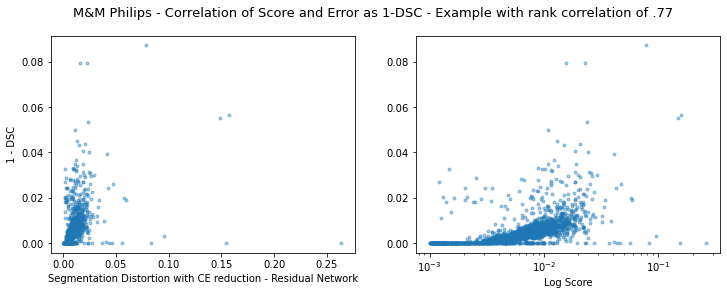

In [92]:
data = metrics[0]['corr']
p = data.preds
t = data.target

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
fig.suptitle('M&M Philips - Correlation of Score and Error as 1-DSC - Example with rank correlation of .77 ', fontsize=13)

axes[0].plot(p, t, '.', alpha=0.4)
axes[1].plot(p, t, '.', alpha=0.4)
axes[1].set_xscale('log')
#axes[1].set_yscale('log')

axes[0].set_ylabel("1 - DSC")
axes[0].set_xlabel("Segmentation Distortion with CE reduction - Residual Network")
#axes[1].set_ylabel("Log Error")
axes[1].set_xlabel("Log Score")

fig.savefig("../../../results-tmp/results/eval/example_scatter.jpg", bbox_inches='tight', dpi=400)
# plt.plot(metrics[0]['corr'].preds, metrics[0]['corr'].target, '.', alpha=0.4)
# plt.xscale('log')
# plt.yscale('log')

In [105]:
data = metrics[0]['corr']
p = np.array([p.item() for p in data.preds])
t = np.array([t.item() for t in data.target])

In [114]:
df = pd.DataFrame()
df['p'] = np.log(p)
df['t'] = t

<AxesSubplot:xlabel='p', ylabel='t'>

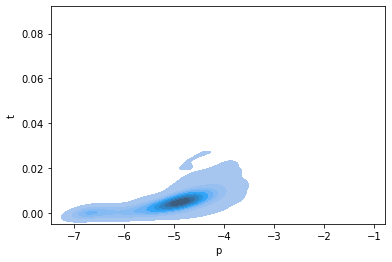

In [115]:
sns.kdeplot(data=df, x='p', y='t',fill=True)
#plt.xscale('log')

In [52]:
disabled_ids = ['shortcut0', 'shortcut1', 'shortcut2']
post = 'localAug_multiImgSingleView_recon_balanced_same'


DAEs = nn.ModuleDict({'up3': AugResDAE(in_channels = 64, 
                             in_dim      = 32,
                             latent_dim  = 256 if net_out=='mms' else 64,
                             depth       = 3,
                             block_size  = 4,
                             residual    = False)})


for layer_id in disabled_ids:
    DAEs[layer_id] = nn.Identity()

for i, unet in enumerate(tqdm(unets)):

    model = Frankenstein(seg_model=unet,
                         transformations=DAEs,
                         disabled_ids=disabled_ids,
                         copy=True)
    model_path = f'{ROOT}pre-trained-tmp/trained_AEs/acdc_AugResDAE{i}_{post}_best.pt'
    #model_path = f'{ROOT}pre-trained-tmp/trained_AEs/{pre}_resDAE{i}_{post}_best.pt'
    #model_path = f'{ROOT}pre-trained-tmp/trained_AEs/acdc_epinet_CE-only_prior-1_best.pt'
    #model_path = f'{ROOT}pre-trained-tmp/trained_AEs/acdc_resDAE0_venus_best.pt'
    state_dict = torch.load(model_path)['model_state_dict']
    model.load_state_dict(state_dict)

    metrics.append({})
    detector = MeanDistSamplesDetector(model=model,
                                       valid_loader=None,
                                       net_out=net_out,
                                       umap_method='cross_entropy',
                                       umap_reduction='mean',
                                       criterion=criterion)

    metrics[i]['corr'] = detector.testset_correlation(test_loader)

  0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
metrics[0]['corr'].compute()

tensor(0.7607)

In [20]:
metrics[0]['corr'].compute()

tensor(0.5825)

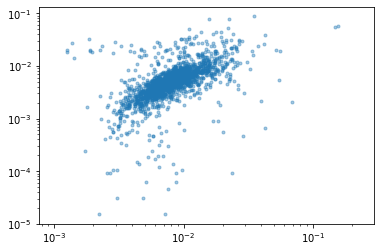

In [70]:
plt.plot(metrics[0]['corr'].preds, metrics[0]['corr'].target, '.', alpha=0.4)
plt.xscale('log')
plt.yscale('log')

(array([511., 995., 761., 180.,  90.,  41.,  28.,  12.,   3.,   4.,   1.,
          5.,   0.,   0.,   1.,   2.,   0.,   0.,   1.,   1.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([0.00099809, 0.00449617, 0.00799424, 0.01149232, 0.0149904 ,
        0.01848848, 0.02198656, 0.02548463, 0.02898271, 0.03248079,
        0.03597887, 0.03947694, 0.04297502, 0.0464731 , 0.04997118,
        0.05346925, 0.05696733, 0.06046541, 0.06396349, 0.06746157,
        0.07095964, 0.07445772, 0.0779558 , 0.08145388, 0.08495195,
        0.08845003, 0.09194811, 0.09544619, 0.09894426, 0.10244234,
        0.10594042, 0.1094385 , 0.11293658, 0.11643465, 0.11993273,
        0.12343081, 0.12692889, 0.13042696, 0.13392504, 0.13742312,
        0.1409212 , 0.

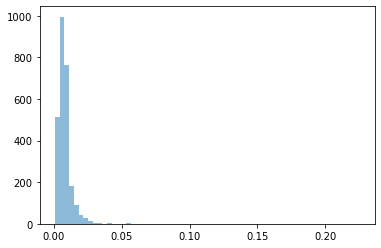

In [65]:
plt.hist(np.array([corr.item() for corr in metrics[0]['corr'].preds]), bins=64, alpha=0.5)

In [54]:
x = torch.tensor(metrics[0]['corr'].preds)

In [55]:
x.median()

tensor(0.0075)

In [57]:
np.array(metrics[0]['corr'].preds).shape

(2642,)

In [64]:
np.array([corr.item() for corr in metrics[0]['corr'].preds])

array([0.00353999, 0.00514162, 0.00866608, ..., 0.00991784, 0.01000004,
       0.04226998])